# AWS Marketplace Product Usage Demonstration - household energyconsumption Model Package

## DefenSight householdenergy consumption

This sample notebook demonstrates the usage of the DefenSight householdenergy consumption.
This solution is a superviser learning model to detect the future values based on past activity in the enterprise network.

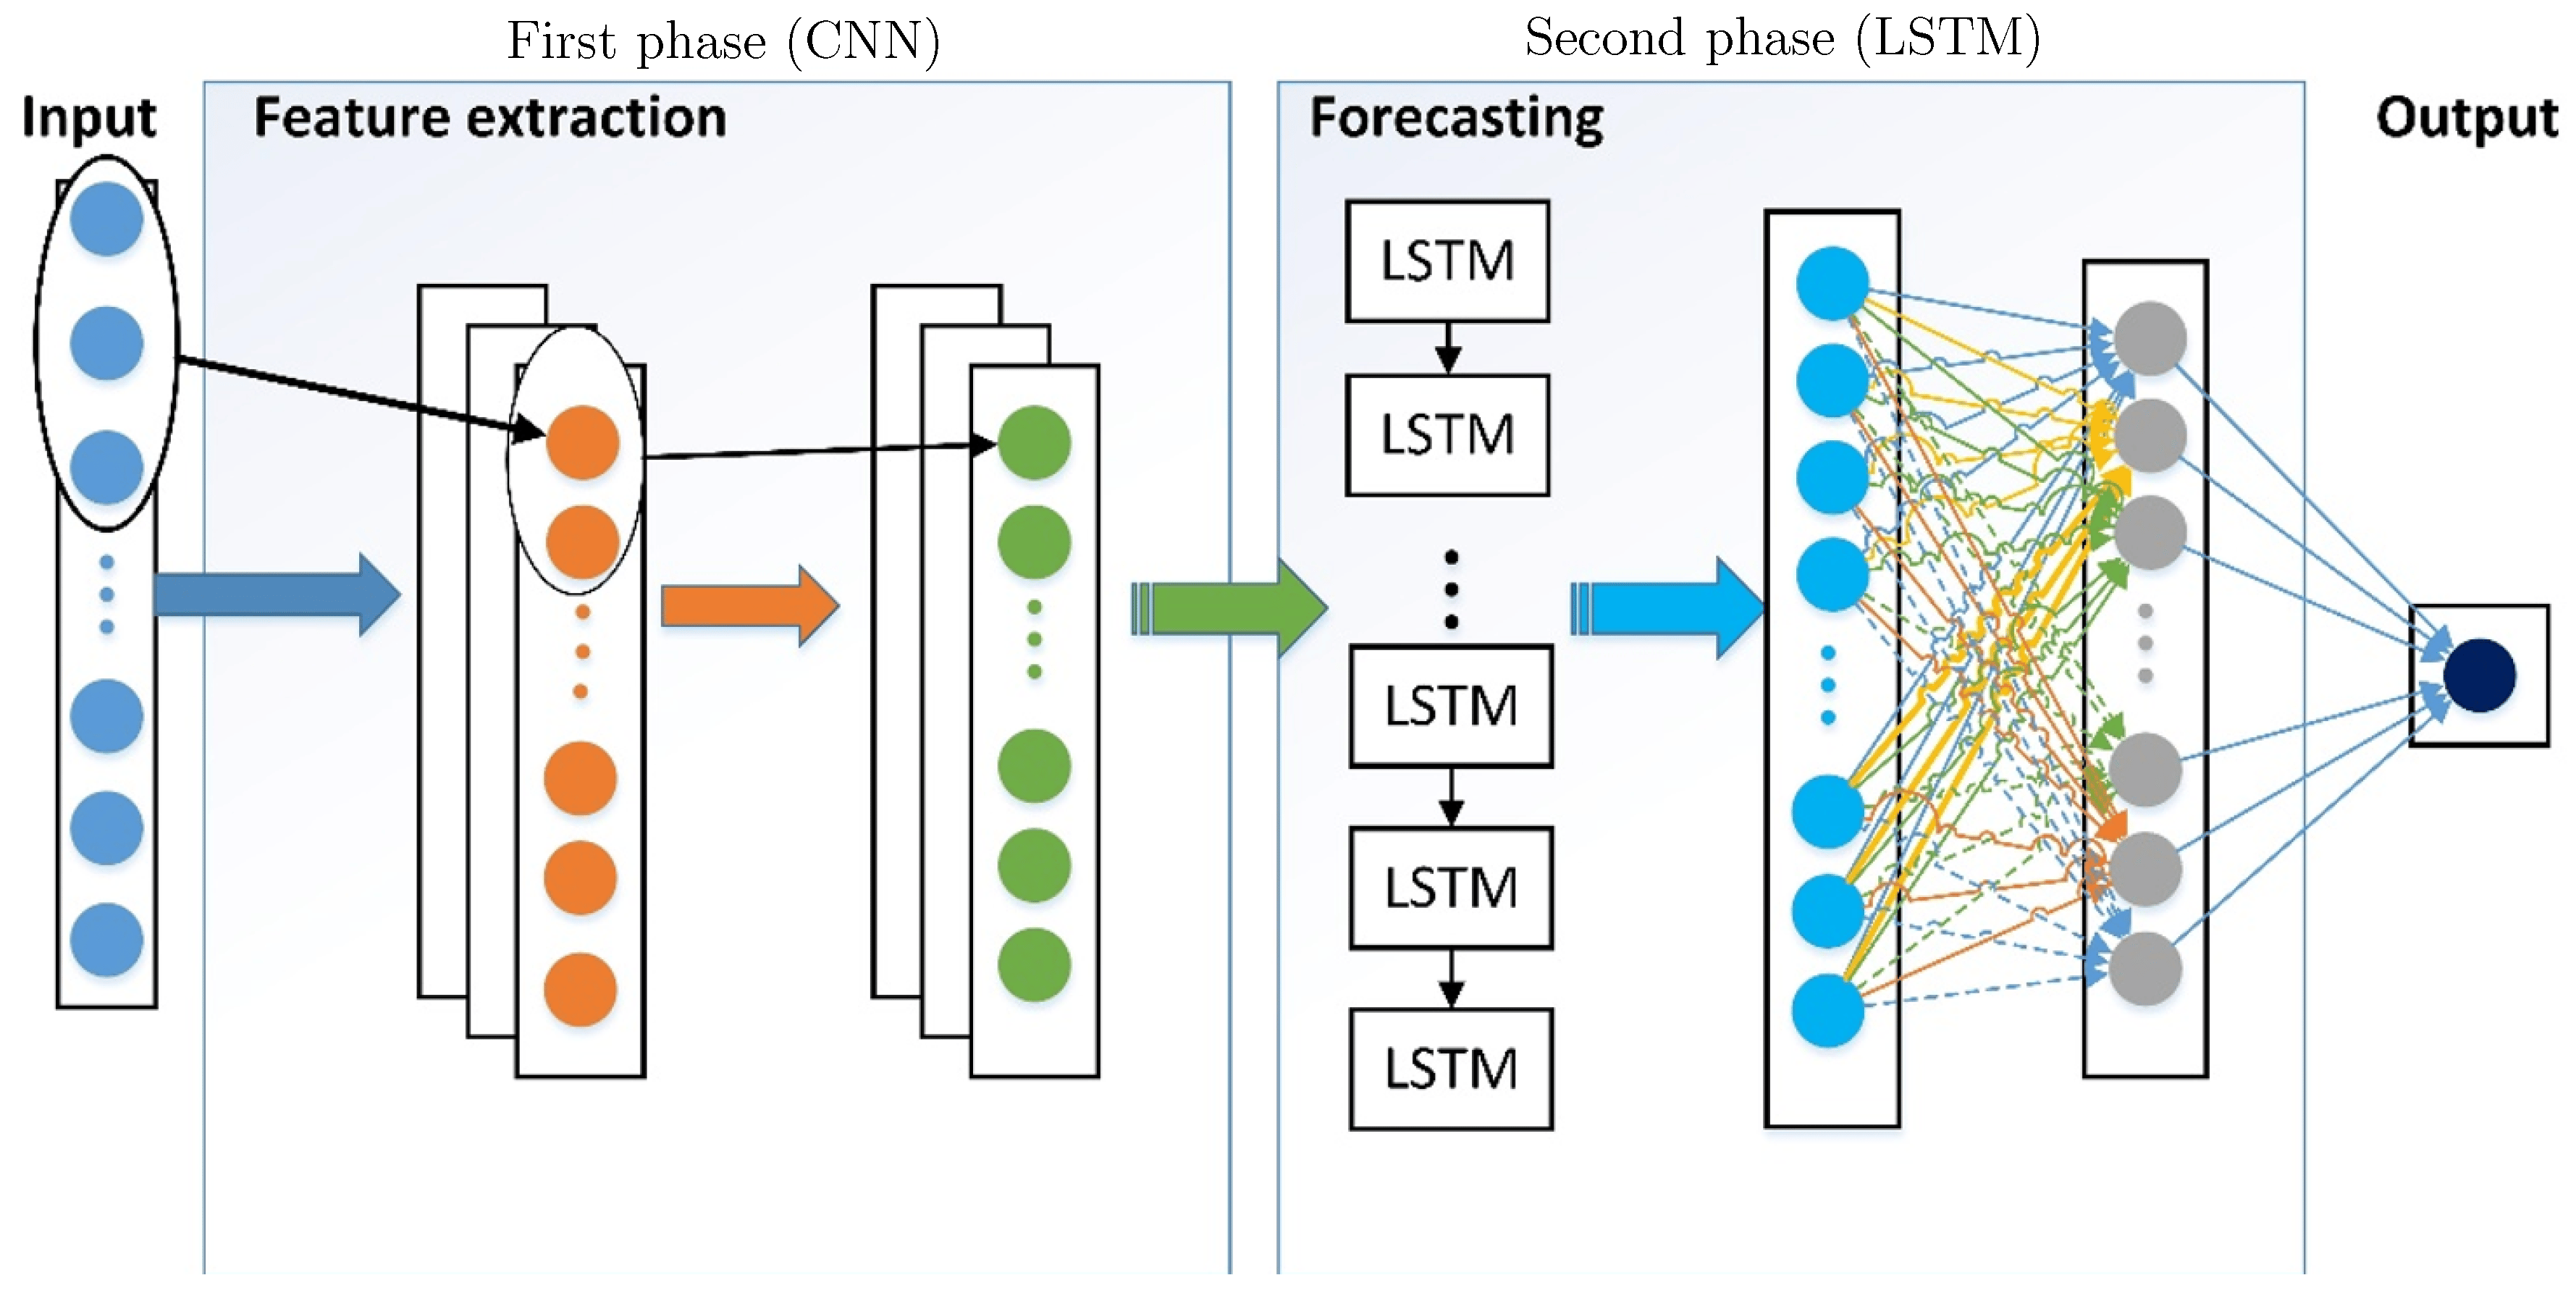

This sample notebook shows you how to deploy DefenSight householdenergy consumption using Amazon SageMaker.

**Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to DefenSight Botnet Detector. If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)

#### Contents:
1. [Subscribe to the model package](# Subscribe-to-the-model-package)
2. [Set up the environment](# Setup the environment)
3. [Create the session](# Create the session)
4. [Create Model](# Create model)
5. [Create an endpoint and perform real-time inference](#-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-input-payload)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Visualize output](#D.-Visualize-output)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
6. [Perform batch inference](# Perform-batch-inference)
    1. [Configure the input S3 bucket folder](# A. -Configure the input S3 bucket folder)
    2. [Deploy the model](# B. -Deploy the model)
    3. [Download the file from output S3 bucket folder](# C. -Download the file from output S3 bucket folder)
    4. [Visualize data](# D. -Visualize data)
7. [Clean-up](# Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))
    

#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

## 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page DefenSight Botnet Detector. 
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

## 2. Set up the environment

In [7]:
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from sagemaker.serializers import CSVSerializer
import boto3
import json

role = get_execution_role()

# S3 prefixes
common_prefix = "hdts-sagemaker-testing"
batch_inference_input_prefix = "energyconsumption/input"
batch_inference_output_prefix = "energyconsumption/output"
from sagemaker.predictor import Predictor

## 3. Create the session

The session remembers our connection parameters to Amazon SageMaker. We'll use it to perform all of our Amazon SageMaker operations.

In [8]:
sagemaker_session = sage.Session()

## 4. Create Model

Now we use the above Model Package to create a model

In [9]:
model_package_arn = 'arn:aws:sagemaker:us-east-1:822940408628:model-package/householdenergy'

In [10]:
model_name = 'householdenergy'

content_type = 'application/json'

real_time_inference_instance_type = 'ml.t2.medium'
batch_transform_inference_instance_type = 'ml.m5.large'

In [11]:
def predict_wrapper(endpoint, session):
    return sage.predictor.Predictor(endpoint, session, content_type)

# Create a deployable model from the model package
model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls = predict_wrapper)

## 5. Create-an-endpoint-and-perform-real-time-inference

#### A. Create an endpoint

In [12]:
#Deploy the model
predictor = model.deploy(1,real_time_inference_instance_type,endpoint_name = model_name)

---------!

Once endpoint has been created, you would be able to perform real-time inference.

#### B. Create input payload

In [13]:
file_name = 'input/test.json'

#### C. Perform real-time inference

In [14]:
!aws sagemaker-runtime invoke-endpoint \
    --endpoint-name $model_name \
    --body fileb://$file_name \
    --content-type $content_type \
    --region $sagemaker_session.boto_region_name \
    output.txt

{
    "ContentType": "text/plain; charset=utf-8",
    "InvokedProductionVariant": "AllTraffic"
}


#### D. Visualize output

In [15]:
with open('output.txt', 'r') as f:
    output = json.load(f)
print(json.dumps(output,indent=1))

0.8120726346969604


#### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [16]:
predictor.delete_endpoint(delete_endpoint_config = True)

## 6. Perform batch inference

In this section, you will perform batch inference using multiple input payloads together. If you are not familiar with batch transform, and want to learn more, see these links:
1. [How it works](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html)
2. [How to run a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html)

### A. Configure the input S3 bucket folder

In [17]:
transform_input_folder = 'input'
transform_input = sagemaker_session.upload_data(transform_input_folder,common_prefix,batch_inference_input_prefix)

### B. Deploy the model

In [18]:
transformer = model.transformer(1,batch_transform_inference_instance_type,output_path="s3://"+common_prefix+"/"+batch_inference_output_prefix+"/")
transformer.transform(transform_input,content_type=content_type)
transformer.wait()

INFO:sagemaker:Creating transform job with name: householdenergy-2023-08-30-09-48-07-885


............................Starting the inference server with 2 workers.
[2023-08-30 09:52:45 +0000] [9] [INFO] Starting gunicorn 21.2.0
[2023-08-30 09:52:45 +0000] [9] [INFO] Listening at: unix:/tmp/gunicorn.sock (9)
[2023-08-30 09:52:45 +0000] [9] [INFO] Using worker: sync
[2023-08-30 09:52:45 +0000] [12] [INFO] Booting worker with pid: 12
[2023-08-30 09:52:45 +0000] [14] [INFO] Booting worker with pid: 14
2023-08-30 09:52:46.196560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 09:52:46.211778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operation

#0151/1 [==============================] - ETA: 0s#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0151/1 [==============================] - 1s 1s/step
169.254.255.130 - - [30/Aug/2023:09:52:57 +0000] "POST /invocations HTTP/1.1" 200 18 "-" "Go-http-client/1.1"
2023-08-30T09:52:56.174:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD


### C. Download the file from output S3 bucket folder

In [19]:
import os
s3_conn = boto3.client("s3")
with open('output2.txt','wb') as f:
    s3_conn.download_fileobj(common_prefix,batch_inference_output_prefix+'/'+'test.json.out',f)
    print("Output file loaded from bucket")

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Output file loaded from bucket


### D. Visualize data

In [20]:
with open('output2.txt','r') as f:
    output = json.load(f)
print(json.dumps(output,indent=1))

0.8120726346969604


### 4. Clean-up

### A. Delete the model

In [21]:
model.delete_model()

INFO:sagemaker:Deleting model with name: householdenergy-2023-08-30-09-48-07-096


#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.